## Disclaimer

This notebook accompanies the paper:

*Multi-scale Topology Optimization using Neural Networks*.  
arXiv preprint [arXiv:2404.08708](https://arxiv.org/abs/2404.08708), 2024.

and 

*Heterogeneous Metamaterials Design via Multiscale Neural Implicit Representation*

The code is provided for academic and research purposes only. While we aim for clarity and reproducibility, this implementation may not cover all aspects of the paper, and some details may be simplified or adapted for illustrative purposes.

If you use this code or build upon it in your own work, please cite the above paper.

---

## License

This project is licensed under the [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).  
You are free to use, modify, and distribute this code under the terms of the license. See the `LICENSE` file for details.

---

**Note:** This code is provided "as is", without warranty of any kind, express or implied. The authors are not responsible for any damages or issues arising from the use of this code.


In [1]:
import numpy as np

from scipy.sparse import coo_matrix, csc_matrix, hstack, vstack
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from IPython import display

import math as m


# Get a list of all available GPUs
gpus = tf.config.list_physical_devices('GPU')

# # Disable GPU if available
# if gpus:
#     try:
#         tf.config.set_visible_devices([], 'GPU')
#         print("GPU disabled, running on CPU")
#     except RuntimeError as e:
#         print(e)

In [2]:
class StructuralFE:

    def __init__(self, nelx,nely):
        self.nely, self.nelx = nely,nelx
        self.nele = nelx*nely
        self.penal = 2.0


    def getDMatrix(self):
        E=1
        nu=0.3
        k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
        KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
        return (KE);
    #-----------------------#
    def initializeSolver(self, Emin = 1e-3, Emax = 1.0):
        self.Emin = Emin;
        self.Emax = Emax;
        self.ndof = 2*(self.nelx+1)*(self.nely+1)
        self.KE=self.getDMatrix();
        dofs=np.arange(self.ndof);

        self.d1 = np.array([self.nely*2,self.nely*2+1, (self.nely+1)*(self.nelx+1)*2-2, (self.nely+1)*(self.nelx+1)*2-1, (self.nely+1)*(self.nelx)*2, (self.nely+1)*(self.nelx)*2+1, 0, 1])
        self.d3 = np.concatenate([np.arange(self.nely*2-2)+2, np.repeat((self.nely+1)*4-2+np.arange(self.nelx-1)*(self.nely+1)*2,2) +  np.tile([0, 1], self.nelx-1)])  
        self.d4 = np.concatenate([np.arange(self.nely*2-2)+2 + (self.nely+1)*(self.nelx)*2,  np.repeat( (self.nely+1)*2+np.arange(self.nelx-1)*(self.nely+1)*2 ,2) +  np.tile([0, 1], self.nely-1)])
        self.d2 = np.setdiff1d(np.arange(self.ndof),np.concatenate([self.d1,self.d3,self.d4]))

        e0 = np.eye(3)
        self.ufixed = np.zeros((8, 3))

        for j in range(3):
            self.ufixed[2:4, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[self.nelx], [0]])).flatten()
            self.ufixed[6:8, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[0], [self.nely]])).flatten()
            self.ufixed[4:6, j] = self.ufixed[2:4, j] + self.ufixed[6:8, j]

        self.wfixed = np.vstack([np.tile(self.ufixed[2:4, :], (self.nely - 1,1)), np.tile(self.ufixed[6:8, :], (self.nelx - 1,1))])
        
        self.edofMat=np.zeros((self.nelx*self.nely,8),dtype=int)
        for elx in range(self.nelx):
            for ely in range(self.nely):
                el = ely+elx*self.nely
                n1=(self.nely+1)*elx+ely
                n2=(self.nely+1)*(elx+1)+ely
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten()
        self.beta = [1.0, 2.0, 0.0, 1.0, 0.0, 0.0]

    #-----------------------#
    @tf.custom_gradient
    def compliance(self, density):
        density = np.reshape(tf.transpose(density),[1,-1])
        self.u=np.zeros((self.ndof,3))
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(0.01 + density)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()
        self.K = K
        Kr1 = hstack([K[self.d2, :][:, self.d2], K[self.d2,:][:,self.d3] + K[self.d2,:][:, self.d4] ])
        Kr2 = hstack([K[self.d3,:][:, self.d2] + K[self.d4,:][:,self.d2] , K[self.d3,:][:,self.d3] + K[self.d4,:][:,self.d3] + K[self.d3,:][:,self.d4] + K[self.d4,:][:,self.d4]])
        Kr = vstack([Kr1, Kr2 ])

        self.u[self.d1,:] = self.ufixed
        KU = np.vstack([K[self.d2,:][:,self.d1].toarray(), K[self.d3,:][:,self.d1].toarray() + K[self.d4,:][:,self.d1].toarray()]) @ self.ufixed
        KW = np.vstack([K[self.d2,:][:,self.d4].toarray(), K[self.d3,:][:,self.d4].toarray() + K[self.d4,:][:,self.d4].toarray()]) @ self.wfixed

        self.u[np.hstack([self.d2,self.d3]), :] = spsolve(Kr.tocsc(),- KU - KW)

        self.u[self.d4,:] = self.u[self.d3,:] + self.wfixed

        Ei = self.Emin + density**self.penal*(self.Emax-self.Emin)
        qe_11 = np.sum((np.dot(self.u[self.edofMat,0].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,0].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 
        qe_12 = np.sum((np.dot(self.u[self.edofMat,0].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,1].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 
        qe_13 = np.sum((np.dot(self.u[self.edofMat,0].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,2].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 
        qe_22 = np.sum((np.dot(self.u[self.edofMat,1].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,1].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 
        qe_23 = np.sum((np.dot(self.u[self.edofMat,1].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,2].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 
        qe_33 = np.sum((np.dot(self.u[self.edofMat,2].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat,2].reshape(self.nelx*self.nely,8) ), axis=1) /self.nele 

        Q_11,Q_12,Q_13,Q_22,Q_23,Q_33 = qe_11@Ei.T, qe_12@Ei.T, qe_13@Ei.T, qe_22@Ei.T, qe_23@Ei.T, qe_33@Ei.T

        self.Q_11,self.Q_12,self.Q_13,self.Q_22,self.Q_23,self.Q_33 = Q_11,Q_12,Q_13,Q_22,Q_23,Q_33
        c = -(self.beta[0]*Q_11+ self.beta[1]*Q_12 + self.beta[2]*Q_13 + self.beta[3]*Q_22 + self.beta[4]*Q_23 + self.beta[5]*Q_33)

        c = tf.convert_to_tensor(c, dtype=tf.float32)
        def grad(dy):
            dc = dy* self.penal*density**(self.penal - 1.0)*(self.beta[0]*qe_11+ self.beta[1]*qe_12 + self.beta[2]*qe_13 + self.beta[3]*qe_22 + self.beta[4]*qe_23 + self.beta[5]*qe_33)
            dc = tf.convert_to_tensor(dc,dtype = tf.float32)
            return tf.reshape(dc,[-1,1])
        return c, grad


In [3]:
def HM2D(rho, Emax,Emin,nu,penal):
    nely,nelx = rho.shape

    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = Emax/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);

    ndof = 2*(nelx+1)*(nely+1)
    dofs=np.arange(ndof)

    d1 = np.array([nely*2,nely*2+1, (nely+1)*(nelx+1)*2-2, (nely+1)*(nelx+1)*2-1, (nely+1)*(nelx)*2, (nely+1)*(nelx)*2+1, 0, 1])
    d3 = np.concatenate([np.arange(nely*2-2)+2, np.repeat((nely+1)*4-2+np.arange(nelx-1)*(nely+1)*2,2) +  np.tile([0, 1], nelx-1)])  
    d4 = np.concatenate([np.arange(nely*2-2)+2 + (nely+1)*(nelx)*2,  np.repeat( (nely+1)*2+np.arange(nelx-1)*(nely+1)*2 ,2) +  np.tile([0, 1], nely-1)])
    d2 = np.setdiff1d(np.arange(ndof),np.concatenate([d1,d3,d4]))

    e0 = np.eye(3)
    ufixed = np.zeros((8, 3))

    for j in range(3):
        ufixed[2:4, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[nelx], [0]])).flatten()
        ufixed[6:8, j] = np.dot(np.array([[e0[0, j], e0[2, j] / 2], [e0[2, j] / 2, e0[1, j]]]), np.array([[0], [nely]])).flatten()
        ufixed[4:6, j] = ufixed[2:4, j] + ufixed[6:8, j]

    wfixed = np.vstack([np.tile(ufixed[2:4, :], (nely - 1,1)), np.tile(ufixed[6:8, :], (nelx - 1,1))])
    
    edofMat=np.zeros((nelx*nely,8),dtype=int)
    for elx in range(nelx):
        for ely in range(nely):
            el = ely+elx*nely
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely
            edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

    iK = np.kron(edofMat,np.ones((8,1))).flatten()
    jK = np.kron(edofMat,np.ones((1,8))).flatten()
    Q_11,Q_12,Q_13,Q_22,Q_23,Q_33 = 0,0,0,0,0,0

    density = np.reshape(tf.transpose(rho),[1,-1])
    u=np.zeros((ndof,3))
    # solve
    sK=((KE.flatten()[np.newaxis]).T*(Emin+(1e-6+ density)**penal*(Emax-Emin))).flatten(order='F')
    K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
    K = K
    Kr1 = hstack([K[d2, :][:, d2], K[d2,:][:,d3] + K[d2,:][:, d4] ])
    Kr2 = hstack([K[d3,:][:, d2] + K[d4,:][:,d2] , K[d3,:][:,d3] + K[d4,:][:,d3] + K[d3,:][:,d4] + K[d4,:][:,d4]])
    Kr = vstack([Kr1, Kr2 ])

    u[d1,:] = ufixed
    KU = np.vstack([K[d2,:][:,d1].toarray(), K[d3,:][:,d1].toarray() + K[d4,:][:,d1].toarray()]) @ ufixed
    KW = np.vstack([K[d2,:][:,d4].toarray(), K[d3,:][:,d4].toarray() + K[d4,:][:,d4].toarray()]) @ wfixed

    u[np.hstack([d2,d3]), :] = spsolve(Kr.tocsc(),- KU - KW)

    u[d4,:] = u[d3,:] + wfixed

    Ei = Emin + density**penal*(Emax-Emin)
    qe_11 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,0].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_12 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,1].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_13 = np.sum((np.dot(u[edofMat,0].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_22 = np.sum((np.dot(u[edofMat,1].reshape(nelx*nely,8),KE) * u[edofMat,1].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_23 = np.sum((np.dot(u[edofMat,1].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)
    qe_33 = np.sum((np.dot(u[edofMat,2].reshape(nelx*nely,8),KE) * u[edofMat,2].reshape(nelx*nely,8) ), axis=1)/(nely*nelx)

    Q_11,Q_12,Q_13,Q_22,Q_23,Q_33 = qe_11@Ei.T, qe_12@Ei.T, qe_13@Ei.T, qe_22@Ei.T, qe_23@Ei.T, qe_33@Ei.T
    
    ET = np.array([[Q_11,Q_12,Q_13],[Q_12,Q_22,Q_23],[Q_13,Q_23,Q_33]])

    dET = np.array([[qe_11.reshape([nely,nelx],order='F'),qe_12.reshape([nely,nelx],order='F'),qe_13.reshape([nely,nelx],order='F')],
                    [qe_12.reshape([nely,nelx],order='F'),qe_22.reshape([nely,nelx],order='F'),qe_23.reshape([nely,nelx],order='F')],
                    [qe_13.reshape([nely,nelx],order='F'),qe_23.reshape([nely,nelx],order='F'),qe_33.reshape([nely,nelx],order='F')]]) * penal * rho **(penal-1.0)

    return ET[:,:,0], dET
                  

def elementMatVec2D(a, b, DH):
    GaussNodes = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
    GaussWeight = np.array([1, 1])
    L = np.array([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 1, 1, 0]])
    Ke = np.zeros((8, 8))
    
    for i in range(len(GaussNodes)):
        for j in range(len(GaussNodes)):
            GN_x = GaussNodes[i]
            GN_y = GaussNodes[j]
            dN_x = 1 / 4 * np.array([-(1 - GN_x), (1 - GN_x), (1 + GN_x), -(1 + GN_x)])
            dN_y = 1 / 4 * np.array([-(1 - GN_y), -(1 + GN_y), (1 + GN_y), (1 - GN_y)])
            J = np.dot(np.vstack((dN_x, dN_y)), np.array([[-a, a, a, -a], [-b, -b, b, b]]).T)
            G = np.block([[np.linalg.inv(J), np.zeros_like(J)],
                          [np.zeros_like(J), np.linalg.inv(J)]])
            dN = np.zeros((4, 8))
            dN[0,0:8:2] = dN_x
            dN[1,0:8:2] = dN_y
            dN[2,1:8:2] = dN_x
            dN[3,1:8:2] = dN_y
            Be = (L @ G) @ dN
            Ke += GaussWeight[i] * GaussWeight[j] * np.linalg.det(J) * (Be.T @ DH @ Be)
    
    return Ke



In [4]:

Macro_nelx = 12
Macro_nely = 4
Macro_length = Macro_nelx
Macro_width = Macro_nely 

Macro_vf = 0.3

Macro_nelm = max(Macro_nelx,Macro_nely)
Macro_elex = Macro_length / Macro_nelx
Macro_eley = Macro_width / Macro_nely
Macro_nele = Macro_nelx * Macro_nely

Micro_nelx = 30
Micro_nely = 30
Micro_vf = 0.5
Micro_nelm = max(Micro_nelx,Micro_nely)
Micro_nele = Micro_nelx * Micro_nely

n_ss = 2  # sub-sampling factor per macro element dimension
E0 = 1.0
Emin = 1e-9
nu = 0.3
penal = 3.0

penal_init = 2.0
penal_max = 3.0
penal_delta = 0.005

FE = StructuralFE(Micro_nelx,Micro_nely)
FE.initializeSolver(Emin, E0)
FE.compliance(np.ones([Micro_nelx,Micro_nely]))

Macro_ndof = 2 * (Macro_nelx + 1) * (Macro_nely + 1) 
Macro_index = np.arange(Macro_nele).reshape([Macro_nely,Macro_nelx],order='F')

idx = Macro_nelx-1 
idy = int(Macro_nely)-1


fixeddofs= np.arange(Macro_ndof)[0:2*(Macro_nely+1):1]
fixeddofs = np.concatenate([fixeddofs, np.arange(Macro_ndof)[-(Macro_nely+1)*2:]])

force = np.zeros((Macro_ndof,1))

F = force


freedofs = np.setdiff1d(np.arange(Macro_ndof),fixeddofs);

edofMat=np.zeros((Macro_nelx*Macro_nely,8),dtype=int)
for elx in range(Macro_nelx):
    for ely in range(Macro_nely):
        el = ely+elx*Macro_nely
        n1=(Macro_nely+1)*elx+ely
        n2=(Macro_nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten()


U_t = np.zeros((Macro_ndof, 1))
mask_gamma = np.zeros((Macro_ndof, 1))

# # # Indices to modify

t_indices = np.array([ ((i * (Macro_nely + 1) ) * 2 + 1) for i in range(Macro_nelx + 1) ])
amplitude = 1.0
t_values = amplitude * np.exp(-10.0 * (np.linspace(-1, 1, Macro_nelx + 1))**2/2)

t_values = t_values.reshape(-1, 1)  

U_t[t_indices] = t_values
mask_gamma[t_indices] = 1.0

print("t_indices:", t_indices) 
print("t_values:\n", t_values)

prescribed_dofs  =  fixeddofs             
U_prescribed     = np.concatenate([np.zeros(10),np.array([-1,0,-1,0,-1,0,-1,0,-1,0])]) * 1.0

t_indices: [  1  11  21  31  41  51  61  71  81  91 101 111 121]
t_values:
 [[0.00673795]
 [0.03104796]
 [0.10836802]
 [0.2865048 ]
 [0.57375342]
 [0.87032473]
 [1.        ]
 [0.87032473]
 [0.57375342]
 [0.2865048 ]
 [0.10836802]
 [0.03104796]
 [0.00673795]]


In [5]:
def elementMatVec2D_Batch(a, b, DH_batch):
    nely, nelx, _, _ = DH_batch.shape
    Ke_batch = np.zeros((nely, nelx, 8, 8))
    GaussNodes = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
    GaussWeight = np.array([1,1])

    X_e = np.array([[-a, -b],
                    [ a, -b],
                    [ a,  b],
                    [-a,  b]])  # (4,2)
    L = np.array([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 1, 1, 0]])
    for i_gx, gx in enumerate(GaussNodes):
        for i_gy, gy in enumerate(GaussNodes):
            dN_x = 0.25 * np.array([-(1 - gx), (1 - gx), (1 + gx), -(1 + gx)])
            dN_y = 0.25 * np.array([-(1 - gy), -(1 + gy), (1 + gy), (1 - gy)])
            J = np.vstack((dN_x, dN_y)) @ X_e 
            invJ = np.linalg.inv(J)
            G = np.block([
                [invJ,           np.zeros_like(invJ)],
                [np.zeros_like(invJ), invJ]
            ])  
            dN = np.zeros((4, 8))
            dN[0,0::2] = dN_x
            dN[1,0::2] = dN_y
            dN[2,1::2] = dN_x
            dN[3,1::2] = dN_y
            Be = (L @ G) @ dN  
            BTe = Be.T  
            tmp = np.einsum('ac,xycd->xya d', BTe, DH_batch)  
            Klocal = np.einsum('xyad,db->xyab', tmp, Be)
            fac = GaussWeight[i_gx] * GaussWeight[i_gy] * np.linalg.det(J)
            Ke_batch += fac * Klocal
    return Ke_batch



@tf.custom_gradient
def displacementMS(Macro_x_tf, Micro_x_tf):

    Macro_x = Macro_x_tf.numpy()  # shape [Macro_nely, Macro_nelx]
    Micro_x = Micro_x_tf.numpy()  # shape [Micro_nely, Micro_nelx, Macro_nele]


    sK = np.zeros((64 * Macro_nele,), dtype=float)  
    dDH_all = np.zeros((3,3,Micro_x.shape[0],Micro_x.shape[1],Macro_nele), dtype=float)
    DH_all  = np.zeros((3,3,Macro_nele), dtype=float)
    Ke_all  = np.zeros((8,8,Macro_nele), dtype=float)

    for i in range(Macro_nele):
        row, col = np.where(Macro_index == i)  
        row_i, col_i = row[0], col[0]
        x_i = Macro_x[row_i, col_i]  # a float
        scale_i = Emin + x_i**penal*(E0 - Emin)
        DH_i, dDH_i = HM2D(Micro_x[:,:,i], E0, Emin, nu, penal)
        DH_all[:,:,i] = DH_i
        dDH_all[:,:,:,:,i] = dDH_i
        Ke_i = elementMatVec2D(Macro_elex/2, Macro_eley/2, DH_i)  # shape (8,8)
        Ke_all[:,:,i] = Ke_i
        sK_el = scale_i * Ke_i.flatten(order='F')
        start = 64*i
        sK[start : start+64] = sK_el
    K = coo_matrix((sK, (iK, jK)), shape=(Macro_ndof, Macro_ndof)).tocsc()
    K = (K + K.T)/2.0

    free_dofs = np.setdiff1d(np.arange(Macro_ndof), prescribed_dofs)
    K_uu = K[free_dofs, :][:, free_dofs]
    rhs  = F[free_dofs, 0] - K[free_dofs, :][:, prescribed_dofs] @ U_prescribed

    U_np = np.zeros(Macro_ndof, dtype=float)
    U_np[prescribed_dofs] = U_prescribed
    U_np[free_dofs]       = spsolve(K_uu, rhs)
    U_tf = tf.convert_to_tensor(U_np, dtype=tf.float32)

    def grad(dU_tf):

        dU_np = dU_tf.numpy()  

        psi = np.zeros_like(U_np, dtype=float)
        psi[freedofs] = spsolve(K[freedofs,:][:,freedofs], dU_np[freedofs])

        dU_dMicro = np.zeros_like(Micro_x, dtype=float)

        for i in range(Macro_nele):
            row, col = np.where(Macro_index == i)
            row_i, col_i = row[0], col[0]
            x_i = Macro_x[row_i, col_i]
            scale_i = Emin + x_i**penal*(E0 - Emin)

            edof_i = edofMat[i,:]       
            psi_el = psi[edof_i]      
            U_el   = U_np[edof_i]      
            dDH_i = np.transpose(dDH_all[:,:,:,:,i], (2,3,0,1))

            dKe_batch = elementMatVec2D_Batch(Macro_elex/2, Macro_eley/2, dDH_i)
            dKe_batch *= scale_i

            tmp = np.einsum('xyab,b->xya', dKe_batch, U_el)   

            valmap = - np.einsum('a,xya->xy', psi_el, tmp)
            dU_dMicro[:,:,i] = valmap

        dMacro = tf.zeros_like(Macro_x_tf, dtype=tf.float32)
        dMicro = tf.convert_to_tensor(dU_dMicro, dtype=tf.float32)

        return (dMacro, dMicro)

    return U_tf, grad

In [6]:
c0s = np.zeros([Macro_nelx*n_ss,Macro_nely*n_ss]) 
FE.beta =   [1.0, 2.0, 0.0, 1.0, 0.0, 0.0 ]  #E11, E12, E13, E22, E23, E33

vvvf = 0.5

c0s[:,:] = FE.compliance(np.ones([Micro_nelx,Micro_nely])*vvvf)

In [7]:

alpha_init = 5
alpha_max = 50
alpha_delta = 0.225

u_init = 0
u_max = 1
u_delta = 0.005

c_x, c_y=np.meshgrid(np.linspace(-(Macro_nelx)/(2*Macro_nelm),(Macro_nelx)/(2*Macro_nelm),Macro_nelx),
                                        np.linspace(-(Macro_nely)/(2*Macro_nelm),(Macro_nely)/(2*Macro_nelm),Macro_nely),indexing='ij')

Macro_dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
Macro_dlX = tf.convert_to_tensor(Macro_dlX,dtype=tf.float32)


c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely),indexing='ij')
dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
dlX = tf.convert_to_tensor(dlX,dtype=tf.float32)



low_band = 0.0
high_band = 0.2
c_x, c_y=np.meshgrid(np.linspace(-high_band,high_band,10).reshape([-1]),
                                            np.linspace(-high_band,high_band,10).reshape([-1]),indexing='ij')

dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 0)
kernel1 = tf.Variable(dlInit1,trainable=True,dtype=tf.float32)
weights1 = tf.Variable(tf.zeros([dlInit1.shape[1],1]),trainable=True)

def rbnn1(coord):
    layer1 = tf.sin(tf.matmul(coord, 50.0*kernel1 ) + tf.ones([1,kernel1.shape[1]]))
    rho = tf.nn.sigmoid(tf.matmul(layer1,weights1))
    return rho * 0.0 + 1.0



low_band = 0.0
high_band = 0.3
high_band2 = 0.6

c_x, c_y,c_1,c_2=np.meshgrid(np.linspace(-high_band,high_band,10).reshape([-1]),
                                    np.linspace(-high_band,high_band,10).reshape([-1]),
                                    np.linspace(-high_band2,high_band2,6).reshape([-1]),
                                    np.linspace(-high_band2,high_band2,6).reshape([-1]),indexing='ij')


dlInit2= np.stack((c_x.reshape([-1]),c_y.reshape([-1]),c_1.reshape([-1]),c_2.reshape([-1])),axis = 0)
kernel2 = tf.Variable(dlInit2,trainable=True,dtype=tf.float32)
weights2 = tf.Variable(tf.zeros([dlInit2.shape[1],1])+0.1,trainable=True)
def rbnn2(coord):
    layer1 = tf.sin(tf.matmul(coord, 50.0*kernel2) + tf.ones([1,kernel2.shape[1]]))
    rho = tf.nn.sigmoid(tf.matmul(layer1,weights2))
    return rho

def mask(coord):
    dist = tf.math.sqrt(( coord[:,0]+ 0.4)**2 + (coord[:,2] - 0.2)**2)
    dist = 1 / (1+tf.math.exp(-10* dist))
    return dist




In [8]:

g_x, g_y=np.meshgrid(np.linspace(-0.3,0.3,Macro_nelx*n_ss+2),np.linspace(0.1,0.4,Macro_nely*n_ss+2),indexing='ij')
dlG = np.stack((g_x.reshape([-1]),g_y.reshape([-1])),axis = 1).reshape([Macro_nelx*n_ss+2,Macro_nely*n_ss+2,2])



def m_coords(idx, idy):
    dlXs = np.zeros([Micro_nele,4])
    dlXso = 1.2 *np.array(dlX)

    mxm = (dlXso[:,0]<= -0.5) 
    mxc = (dlXso[:,0]> -0.5) & (dlXso[:,0]< 0.5) 
    mxp = (dlXso[:,0]>= 0.5)
    mym = (dlXso[:,1]<= -0.5) 
    myc = (dlXso[:,1]> -0.5 ) & ( dlXso[:,1]< 0.5) 
    myp = (dlXso[:,1]>= 0.5)

    #n1,top left
    dlXs[mxm & myp,0:2] = dlXso[mxm & myp] + np.array([[1.0,-1.0]]) 
    dlXs[mxm & myp,2:] = dlG[idx,idy+2] 
    #n2, top center
    dlXs[mxc & myp,0:2] = dlXso[mxc & myp] + np.array([[0.0,-1.0]]) 
    dlXs[mxc & myp,2:] = dlG[idx+1,idy+2]
    #n3, top right
    dlXs[mxp & myp,0:2] = dlXso[mxp & myp] + np.array([[-1.0,-1.0]]) 
    dlXs[mxp & myp,2:] = dlG[idx+2,idy+2]
    #n4, center left
    dlXs[mxm & myc,0:2] = dlXso[mxm & myc] + np.array([[1.0,0.0]]) 
    dlXs[mxm & myc,2:] = dlG[idx,idy+1]
    #n5, center 
    dlXs[mxc & myc,0:2] = dlXso[mxc & myc] 
    dlXs[mxc & myc,2:] = dlG[idx+1,idy+1]
    #n6, center right
    dlXs[mxp & myc,0:2] = dlXso[mxp & myc] + np.array([[-1.0,0.0]]) 
    dlXs[mxp & myc,2:] = dlG[idx+2,idy+1]
    #n7,bottom left
    dlXs[mxm & mym,0:2] = dlXso[mxm & mym] + np.array([[1.0,1.0]]) 
    dlXs[mxm & mym,2:] = dlG[idx,idy]
    #n8, bottom center
    dlXs[mxc & mym,0:2] = dlXso[mxc & mym] + np.array([[0.0,1.0]]) 
    dlXs[mxc & mym,2:] = dlG[idx+1,idy]
    #n9, bottom right
    dlXs[mxp & mym,0:2] = dlXso[mxp & mym] + np.array([[-1.0,1.0]]) 
    dlXs[mxp & mym,2:] = dlG[idx+2,idy]


    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

def m_coords_bc(idx, idy,neigh = True):

    dlXs = np.zeros([Micro_nele,4])
    dlXso = 1.1*np.array(dlX)


    mxm = (dlXso[:,0]<= -0.4) 
    mxc = (dlXso[:,0]> -0.4) & (dlXso[:,0]< 0.4) 
    mxp = (dlXso[:,0]>= 0.4)
    mym = (dlXso[:,1]<= -0.4) 
    myc = (dlXso[:,1]> -0.4 ) & ( dlXso[:,1]< 0.4) 
    myp = (dlXso[:,1]>= 0.4)

    #n1,top left
    dlXs[mxm & myp,0:2] = dlXso[mxm & myp] + np.array([[1.0,-1.0]]) 
    dlXs[mxm & myp,2:] = dlG[idx,idy+2] 
    #n2, top center
    dlXs[mxc & myp,0:2] = dlXso[mxc & myp] + np.array([[0.0,-1.0]]) 
    dlXs[mxc & myp,2:] = dlG[idx+1,idy+2]
    #n3, top right
    dlXs[mxp & myp,0:2] = dlXso[mxp & myp] + np.array([[-1.0,-1.0]]) 
    dlXs[mxp & myp,2:] = dlG[idx+2,idy+2]
    #n4, center left
    dlXs[mxm & myc,0:2] = dlXso[mxm & myc] + np.array([[1.0,0.0]]) 
    dlXs[mxm & myc,2:] = dlG[idx,idy+1]
    #n5, center 
    dlXs[mxc & myc,0:2] = dlXso[mxc & myc] 
    dlXs[mxc & myc,2:] = dlG[idx+1,idy+1]
    #n6, center right
    dlXs[mxp & myc,0:2] = dlXso[mxp & myc] + np.array([[-1.0,0.0]]) 
    dlXs[mxp & myc,2:] = dlG[idx+2,idy+1]
    #n7,bottom left
    dlXs[mxm & mym,0:2] = dlXso[mxm & mym] + np.array([[1.0,1.0]]) 
    dlXs[mxm & mym,2:] = dlG[idx,idy]
    #n8, bottom center
    dlXs[mxc & mym,0:2] = dlXso[mxc & mym] + np.array([[0.0,1.0]]) 
    dlXs[mxc & mym,2:] = dlG[idx+1,idy]
    #n9, bottom right
    dlXs[mxp & mym,0:2] = dlXso[mxp & mym] + np.array([[-1.0,1.0]]) 
    dlXs[mxp & mym,2:] = dlG[idx+2,idy]
    

    if not neigh:
        dlXs[:,:2] = dlXso
        dlXs[:,2:] = dlG[idx+1,idy+1]
        
    mk = np.ones([Micro_nele],dtype=bool)
    mk[mxc & myc] = False
    return tf.convert_to_tensor(dlXs[mk],dtype=tf.float32)
def m_coords22(idx, idy,scale=1.0):

    dlXs = np.zeros([Micro_nele,4])
    dlXso = np.array(dlX)

    dlXs[:,0:2] = dlXso*scale 
    dlXs[:,2:] = dlG[idx+1,idy+1]

    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

# Lists for storing micro dlX for each sub-sample
micro_dlX_subsamples   = [[] for _ in range(n_ss*n_ss)]
micro_dlX_bc_subsamples= [[] for _ in range(n_ss*n_ss)]
micro_dlX_bcn_subsamples=[[] for _ in range(n_ss*n_ss)]

# Fill them:
for i in range(Macro_nelx):
    for j in range(Macro_nely):
        for si in range(n_ss):   # 0..n_ss-1 in x
            for sj in range(n_ss): # 0..n_ss-1 in y
                sub_idx = sj*n_ss + si
                # Because originally you had i*2 + si, j*2 + sj when n_ss=2
                Xcoords   = m_coords   (i*n_ss + si, j*n_ss + sj)
                BCcoords  = m_coords_bc(i*n_ss + si, j*n_ss + sj)
                BCcoordsN = m_coords_bc(i*n_ss + si, j*n_ss + sj, False)
                micro_dlX_subsamples[sub_idx].append(Xcoords)
                micro_dlX_bc_subsamples[sub_idx].append(BCcoords)
                micro_dlX_bcn_subsamples[sub_idx].append(BCcoordsN)

# Convert all to TF
for sub_idx in range(n_ss*n_ss):
    micro_dlX_subsamples[sub_idx]    = tf.convert_to_tensor(micro_dlX_subsamples[sub_idx],    dtype=tf.float32)
    micro_dlX_bc_subsamples[sub_idx] = tf.convert_to_tensor(micro_dlX_bc_subsamples[sub_idx], dtype=tf.float32)
    micro_dlX_bcn_subsamples[sub_idx]= tf.convert_to_tensor(micro_dlX_bcn_subsamples[sub_idx],dtype=tf.float32)


SS = 1

c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx*SS),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely*SS),indexing='ij')
dlXSS = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

In [9]:
to_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
to_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
total_epoch = 0


UU = displacementMS(tf.ones([Macro_nely,Macro_nelx]), tf.ones([Micro_nely,Micro_nelx,Macro_nele])*Micro_vf)

log_c = []
log_Macro_vf = []
log_Micro_vf = []


def m_coords2(idx, idy,scale=1.0):

    dlXs = np.zeros([Micro_nele*SS*SS,4])
    dlXso = np.array(dlXSS)

    dlXs[:,0:2] = dlXso*scale 
    dlXs[:,2:] = dlG[idx+1,idy+1]

    return tf.convert_to_tensor(dlXs,dtype=tf.float32)


def to_loss():

    global total_epoch,  penal

    total_epoch = total_epoch+1
    alpha = min(alpha_init + alpha_delta * total_epoch , alpha_max)


    Macro_xPhys =rbnn1(Macro_dlX)

    sub_index = total_epoch % (n_ss*n_ss)
    Micro_dlX   = micro_dlX_subsamples[sub_index]
    Micro_dlX_bc= micro_dlX_bc_subsamples[sub_index]
    Micro_dlX_bcn=micro_dlX_bcn_subsamples[sub_index]
    Micro_xPhys = rbnn2(Micro_dlX)[:,:,0] 
    Micro_xPhys = tf.transpose(Micro_xPhys)
    L2 = tf.reduce_mean((weights2)**2)
    L2_1 = tf.reduce_mean((weights1)**2)
    if total_epoch<10:
        L1_diff = 0.0
    else:
        L1_diff = tf.reduce_mean(tf.abs(rbnn2(Micro_dlX_bc) - rbnn2(Micro_dlX_bcn))) * (alpha/10.0)
    penal = min(penal_init + penal_delta * total_epoch ,penal_max)
    FE.penal = penal
    loss_s = []
    c_grid = np.zeros([Macro_nely*n_ss,Macro_nelx*n_ss])
    i_mod = (total_epoch%n_ss**2 ) // n_ss
    j_mod = (total_epoch%n_ss**2 ) % n_ss
    for i in range(Macro_nelx * n_ss):
        for j in range(Macro_nely * n_ss):
            if i % n_ss == i_mod and j % n_ss == j_mod:

                xPhys_m = rbnn2(tf.reshape(m_coords(i,j),[1,-1,4]))[0,:,:]
                FE.beta =   [1.0, 2.0, 0.0, 1.0, 0.0, 0.0 ]
                c= FE.compliance(xPhys_m)
                vf = tf.math.reduce_mean(xPhys_m)
                loss_s.append(1.0*c/c0s[i,j])
                c_grid[j,i] = c.numpy()
    c = sum(loss_s) / len(loss_s)
    Micro_xPhys_h = tf.reshape(Micro_xPhys, [Micro_nely,Micro_nelx,Macro_nele])
    Micro_xPhys_h = tf.transpose(Micro_xPhys_h,perm = [1,0,2])

    UU = displacementMS(tf.reshape(Macro_xPhys,[Macro_nely,Macro_nelx]), Micro_xPhys_h)
    UU = tf.reshape(UU,[-1,1])

    if total_epoch<0:
        u_coeff = 0.0
        loss_u  = 0.0
    else:
        u_coeff = min(u_init + u_delta * total_epoch , u_max)
        loss_u = tf.reduce_sum( (UU*tf.convert_to_tensor(mask_gamma,dtype=tf.float32) - tf.convert_to_tensor(U_t,dtype=tf.float32) )**2)
    vf_macro = tf.math.reduce_mean(Macro_xPhys)
    vf_micro= tf.math.reduce_mean(Micro_xPhys,axis=0)
    
    loss = 10.0*L2 + L1_diff + 1.0* c+ 10.0*u_coeff*loss_u  + tf.reduce_mean((alpha)*(vf_micro/Micro_vf-1.0)**2 )


    tf.print('Epoch:',total_epoch,',Penal:',penal,',Alpha:',alpha)
    tf.print('Compliance:',c)
    tf.print(f'VF macro: {vf_macro}, micro: {vf_micro}')
    tf.print('Total Loss:',loss)
    tf.print('Loss_u:',loss_u)
    
    log_c.append(np.mean(c_grid))
    log_Macro_vf.append(vf_macro)
    log_Micro_vf.append(vf_micro)
    return loss        

def plot_params():
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title('compliance vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    
    plt.plot(log_c)
    
    plt.subplot(1,3,2)
    plt.title('macro vf vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(log_Macro_vf)

    plt.subplot(1,3,3)
    plt.title('microvf vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.plot(log_Micro_vf)

    plt.show()

def plot_xPhys():

    combined = np.zeros([        Micro_nelx*Macro_nelx*SS*n_ss,        Micro_nely*Macro_nely*SS*n_ss    ])

    for j in range(Macro_nely*n_ss):
        for i in range(Macro_nelx*n_ss):
            dlXss = m_coords2(i, j, 1.0)
            xPhys_m = rbnn2(dlXss).numpy().reshape([Micro_nelx*SS, Micro_nely*SS])
            combined[ i*(Micro_nelx*SS):(i+1)*(Micro_nelx*SS), j*(Micro_nely*SS):(j+1)*(Micro_nely*SS) ] = xPhys_m

    combined = np.rot90(combined)
    combined = np.flip(combined,axis=0)

    plt.figure(figsize = (5,5),dpi=200)
    plt.imshow(combined,vmin=0, vmax=1,cmap = 'seismic')
    plt.axis("off")

    plt.figure(figsize = (10,10))
    xPhys = rbnn1(Macro_dlX) 
    plt.imshow(xPhys.numpy().reshape([Macro_nely,Macro_nelx]),vmin=0, vmax=1,cmap = 'seismic')

    plt.show()

    plt.imshow(np.rot90(tf.reshape(xPhys,[Macro_nelx,Macro_nely])),vmin=0, vmax=1,cmap = 'seismic',origin='lower')
    plt.show()    

def fit_to(epochs):
    for epoch in range(epochs):

        if epoch%5==1:
            display.clear_output(wait=True)
            plot_xPhys()
            plot_params()

        with tf.GradientTape(persistent=True) as model_tape:

            loss = to_loss()
        param2 = [weights2,kernel2]
        grad2 = model_tape.gradient(loss,param2)
        to_optimizer2.apply_gradients(zip(grad2, param2))


        #print(f"memory usage: {tf.config.experimental.get_memory_info('GPU:0')['peak']/(1024**3):.4f} GB")

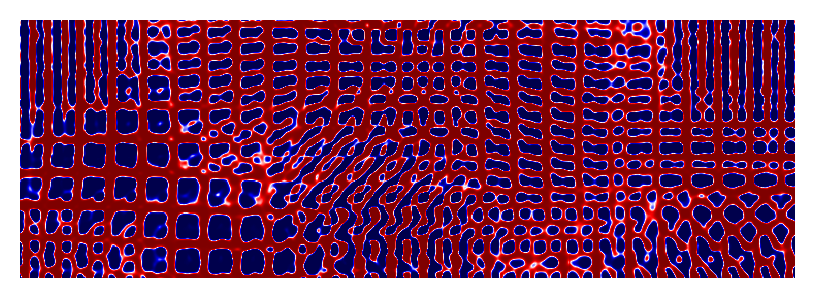

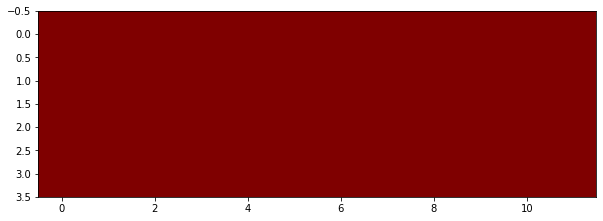

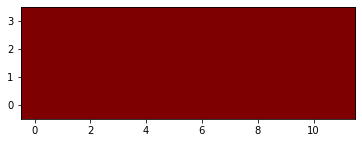

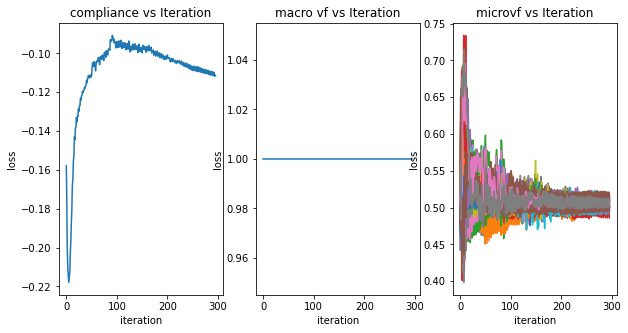

Epoch: 297 ,Penal: 3.0 ,Alpha: 50
Compliance: [0.616545141]
VF macro: 1.0, micro: [0.5039423  0.50601333 0.50684106 0.5117443  0.5069065  0.49254182
 0.51309013 0.5142692  0.5042356  0.5094845  0.5134205  0.5048876
 0.5149185  0.50741434 0.5213997  0.5124169  0.5005504  0.51199013
 0.50087005 0.508388   0.505766   0.5052367  0.5045054  0.49203864
 0.50804865 0.52065504 0.503865   0.51409984 0.5031271  0.50126195
 0.5009787  0.50123715 0.497886   0.5044074  0.49651286 0.51309615
 0.5007833  0.50950146 0.50283206 0.50773716 0.50401974 0.5003358
 0.5057562  0.51041144 0.50907665 0.5019988  0.5070814  0.51343274]
Total Loss: [0.769342482]
Loss_u: 0.00188416545
Epoch: 298 ,Penal: 3.0 ,Alpha: 50
Compliance: [0.629097879]
VF macro: 1.0, micro: [0.49749935 0.50964016 0.49943402 0.4956514  0.5010743  0.5035732
 0.5041342  0.5096211  0.5127968  0.50561285 0.4982944  0.5046905
 0.49474785 0.5060839  0.5040643  0.51623887 0.5068734  0.49645323
 0.49256676 0.50503504 0.5031872  0.49118638 0.5012703

In [10]:
fit_to(300)

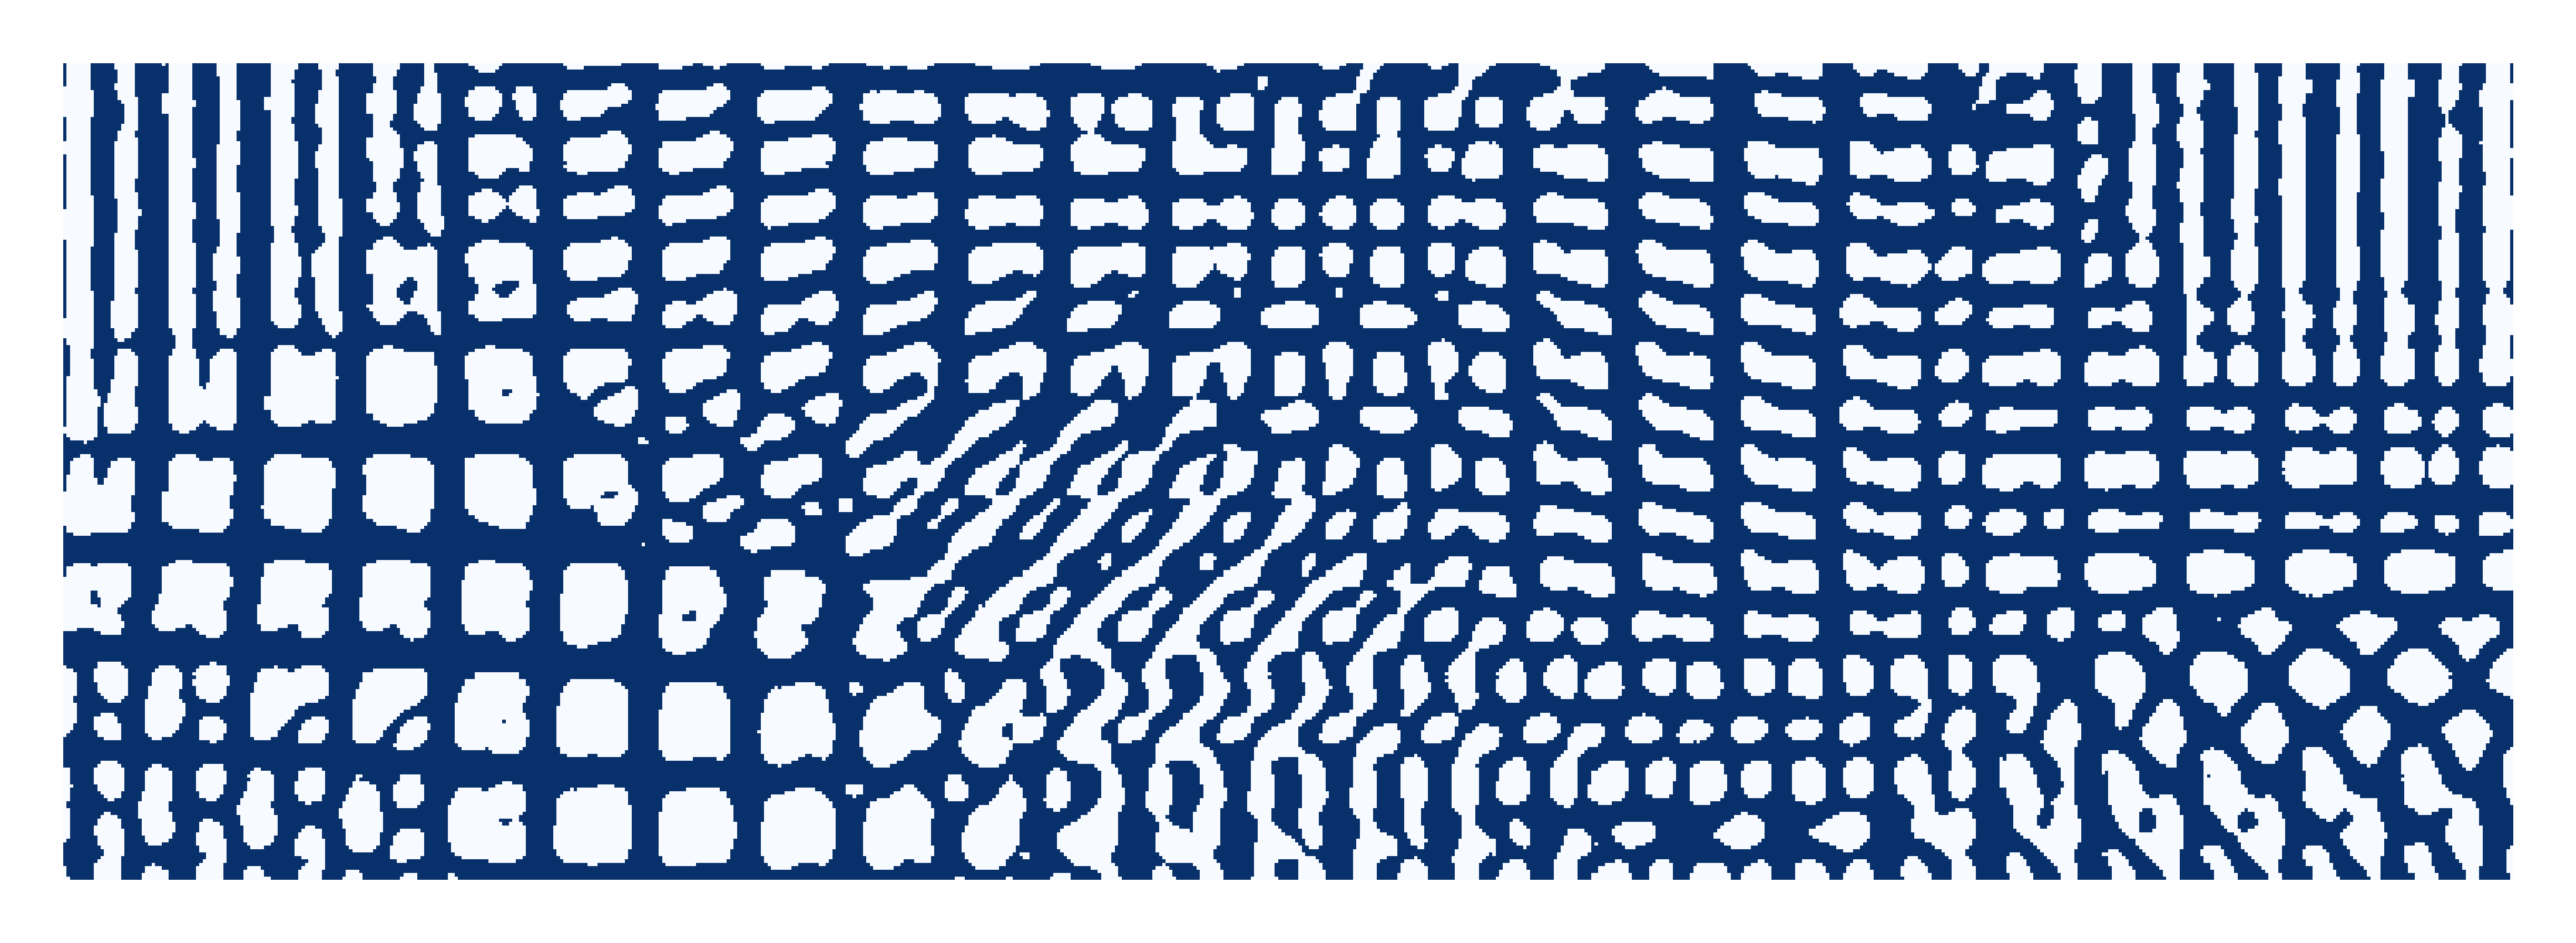

In [11]:
n_ss = 2 #Macro scale upsampling
SS = 1 #Micro scale upsampling

c_x, c_y=np.meshgrid(np.linspace(-(Micro_nelx)/(2*Micro_nelm),(Micro_nelx)/(2*Micro_nelm),Micro_nelx*SS),
                                        np.linspace(-(Micro_nely)/(2*Micro_nelm),(Micro_nely)/(2*Micro_nelm),Micro_nely*SS),indexing='ij')
dlXSS = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])
g_x, g_y=np.meshgrid(np.linspace(-0.3,0.3,Macro_nelx*n_ss+2),np.linspace(0.1,0.4,Macro_nely*n_ss+2),indexing='ij')
dlG = np.stack((g_x.reshape([-1]),g_y.reshape([-1])),axis = 1).reshape([Macro_nelx*n_ss+2,Macro_nely*n_ss+2,2])

def m_coords2(idx, idy,scale=1.0):

    dlXs = np.zeros([Micro_nele*SS*SS,4])
    dlXso = np.array(dlXSS)

    dlXs[:,0:2] = dlXso*scale 
    dlXs[:,2:] = dlG[idx+1,idy+1]

    return tf.convert_to_tensor(dlXs,dtype=tf.float32)

combined = np.zeros([Micro_nelx*Macro_nelx*SS*n_ss, Micro_nely*Macro_nely*SS*n_ss])
for j in range(Macro_nely*n_ss):
    for i in range(Macro_nelx*n_ss):

        dlXss = m_coords2(i,j,1.0)#.numpy()
        xPhys_m = rbnn2(dlXss).numpy().reshape([Micro_nelx*SS,Micro_nely*SS]) #* maskSS.numpy()

        combined[i*Micro_nelx*SS: (i+1)*Micro_nelx*SS, j*Micro_nely*SS: (j+1)*Micro_nely*SS] = xPhys_m
combined = np.rot90(combined,k=1)
combined = np.flip(combined,axis=0)

plt.figure(figsize = (5,3),dpi=1200)
plt.imshow(combined>0.3,vmin=0, vmax=1,cmap = 'Blues',interpolation='nearest')
plt.axis("off")
plt.show()